# Univariate timeseries

In [1]:
# Disable warnings
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sktime.transformations.series.fourier import FourierFeatures
from sktime.forecasting.compose import ForecastingPipeline
from numpyro import distributions as dist

from hierarchical_prophet.sktime.prophet import Prophet

# Import dataset

We import a dataset from Prophet's original repository. We then put it into sktime-friendly format, where the index is a `pd.PeriodIndex` and the colums are the time series.

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv"
)
df["ds"] = pd.to_datetime(df["ds"]).dt.to_period("D")
y = df.set_index("ds")
display(y)

,y
ds,
2007-12-10,9.590761
2007-12-11,8.519590
2007-12-12,8.183677
2007-12-13,8.072467
2007-12-14,7.893572
...,...
2016-01-16,7.817223
2016-01-17,9.273878
2016-01-18,10.333775


# Fit model

Here, we fit the univariate Prophet. Note that we are not using any external regressors but, because of `yearly_seasonality=True`and `weekly_seasonality=True`, they are built internally with sktime's FourierFeatures. As `exogenous_priors` is not passed as hyperparameter, the default values are used for all regressor variables (including the Fourier features). 

In [20]:
import numpyro
from hierarchical_prophet.effects import LinearEffect
model = Prophet(
    trend="linear",
    changepoint_interval=300,
    changepoint_prior_scale=0.0001,
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    weekly_seasonality=True,
    default_exogenous_prior=("Normal", 0, 0.01),
    #exogenous_effects={"sin": ("^sin_.*", LinearEffect("sin", effect_mode="multiplicative"))},
    noise_scale=0.05,
    mcmc_chains=1,
    mcmc_samples=300,
    mcmc_warmup=3000,
    optimizer_name="Adam",
    optimizer_kwargs={"step_size": 0.0001},
    inference_method="mcmc",
)
_ = model.fit(y=y)

sample: 100%|██████████| 3300/3300 [01:57<00:00, 28.17it/s, 1023 steps of size 1.67e-04. acc. prob=0.94]


## Verify the trace of MCMC


Verifying the trace of MCMC is a good way to check if the model has converged. If the trace is not stable, it is a sign that the model has not converged.


In [21]:
#model.plot_trace()
#plt.show()

## Forecasting

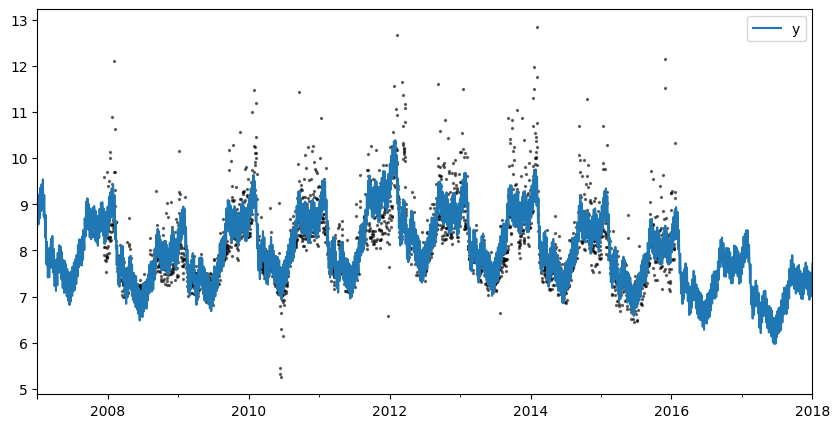

In [22]:
forecast_horizon = pd.period_range("2007-01-01", "2018-01-01", freq="D")
fig, ax = plt.subplots(figsize=(10, 5))
preds = model.predict(fh=forecast_horizon)
preds.plot.line(ax=ax)
ax.scatter(y.index, y, marker="o", color="k", s=2, alpha=0.5)

In [7]:
model.predictive_samples_["obs"].shape

(300, 4019, 1)

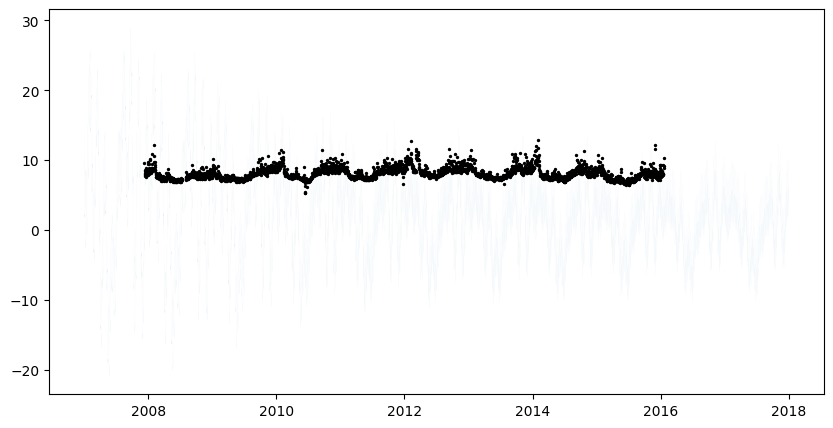

In [8]:
quantiles = model.predict_quantiles(fh=forecast_horizon, alpha=[0.1, 0.9])
fig, ax = plt.subplots(figsize=(10, 5))
# Plot area between quantiles
ax.fill_between(quantiles.index.to_timestamp(), quantiles.iloc[:, 0], quantiles.iloc[:, -1], alpha=0.5)
ax.scatter(y.index, y, marker="o", color="k", s=2, alpha=1)

## Use the hierarchical model to forecast the univariate series

This model is also compatible with univariate timeseries. In this case, however, we need to introduce a dummy hierarchy to the index to the series `y`.

In [9]:
y_hier = y.copy()
# Add constant index level at index level 0, so that y_hier is multiindex
y_hier.index = pd.MultiIndex.from_tuples(
    [("series", i) for i in y_hier.index], names=["hier", "time"]
)
y_hier

y
hier   time                 
series 2007-12-10   9.590761
       2007-12-11   8.519590
       2007-12-12   8.183677
       2007-12-13   8.072467
       2007-12-14   7.893572
...                      ...
       2016-01-16   7.817223
       2016-01-17   9.273878
       2016-01-18  10.333775
       2016-01-19   9.125871
       2016-01-20   8.891374

[2905 rows x 1 columns]

In [10]:
from hierarchical_prophet.sktime.multivariate import HierarchicalProphet
model_hier = HierarchicalProphet(
                mcmc_chains=1,
                mcmc_samples=500,
                mcmc_warmup=1000,
                trend="linear",
                seasonality_mode="additive",
                changepoint_prior_scale=0.01,
                transformer_pipeline=FourierFeatures(
                    fourier_terms_list=[10, 2], sp_list=["Y", "W"]
                ),
                changepoint_interval=300,
                changepoint_range=-8,
                noise_scale=1,
                default_exogenous_prior=(dist.Normal, 0, 0.2),
            )


model_hier.fit(y=y_hier)

ValueError: Dimension must be greater than or equal to 2.

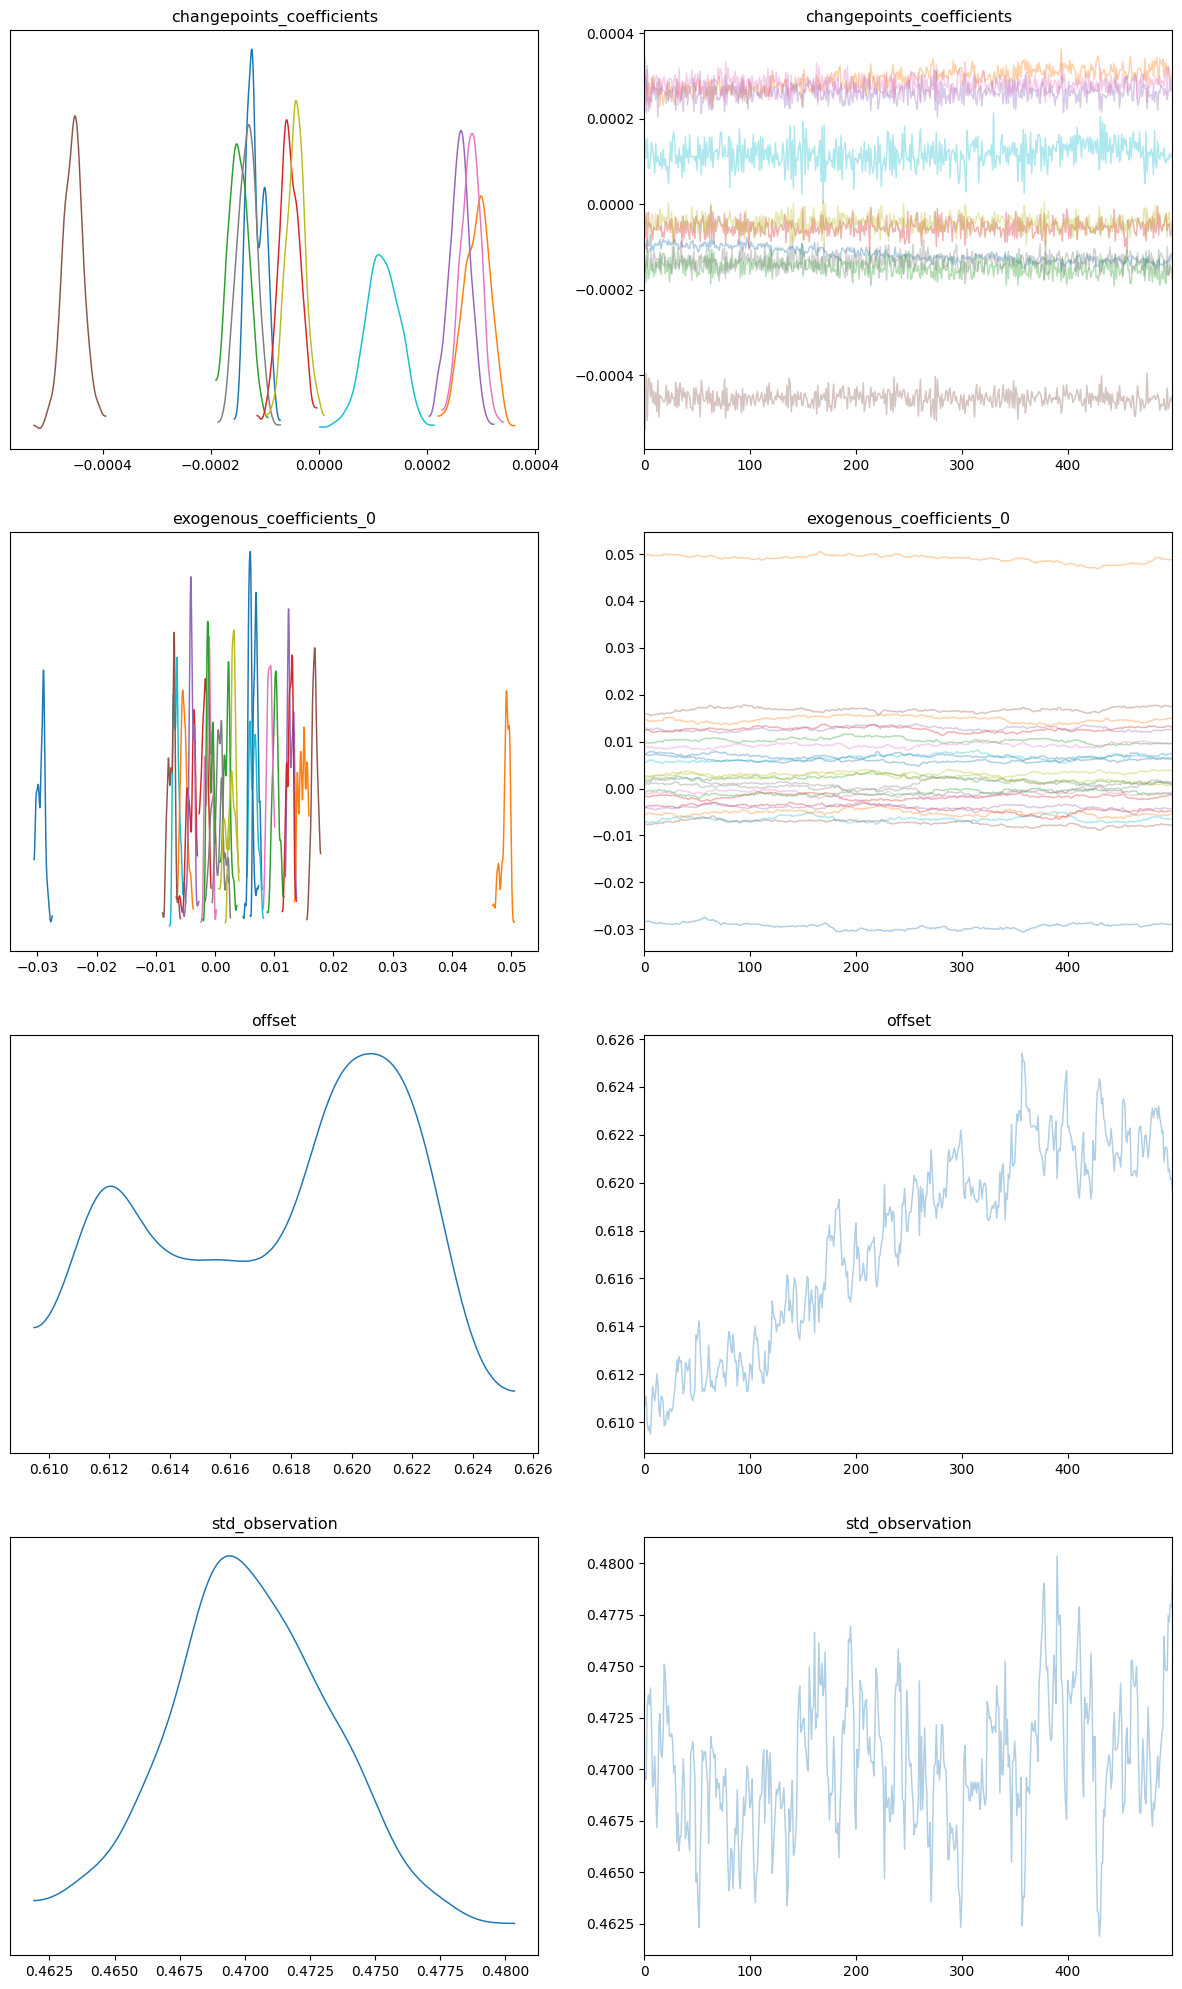

In [ ]:
model_hier.plot_trace()
plt.show()

## Forecasting with hierarchical prophet

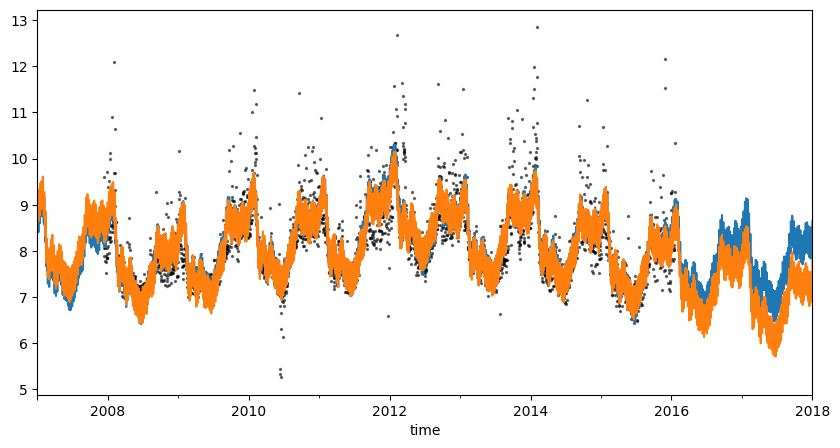

In [ ]:
preds_hier = model_hier.predict(fh=forecast_horizon)

fig, ax = plt.subplots(figsize=(10, 5))

preds_hier.droplevel(0).iloc[:, 0].rename("Hierarchical Prophet").plot.line(ax=ax)
preds.iloc[:, 0].rename("Prophet").plot.line(ax=ax)
# Plot y as scatter plot
ax.scatter(y.index, y, marker="o", color="k", s=2, alpha=0.5)